# CSPB 4622 Programming Assignment 2: Unsupervised Learning - Detecting Credit Card Fraud

## Information

Author: Taylor Larrechea

Kaggle Data Set: [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

GitHub Repository: [P2-QuantumCompiler](https://github.com/cu-cspb-4622-fall-2024/P2-QuantumCompiler)

# Background

The dataset that is included for this assignment corresponds to data that was taken and used for a machine learning model to predict when credit card fraud occurs in credit card transactions. Inside this dataset, there are a total of 31 features, where 28 of the 31 are PCA components that were created from original variables but aren't necessarily real-world features. The other features are made up of Time, Amount, and Class and the meaning of these variables will be discussed further in this notebook. The goal of this assignment is to create a unsupervised learning model that can detect credit card fraud in the dataset.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [13]:
data_path = "./Data/creditcard.csv"
df = pd.read_csv(data_path)

print(df.info)
print(df.head)

<bound method DataFrame.info of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  

# <span style="color:red">EDA</span>

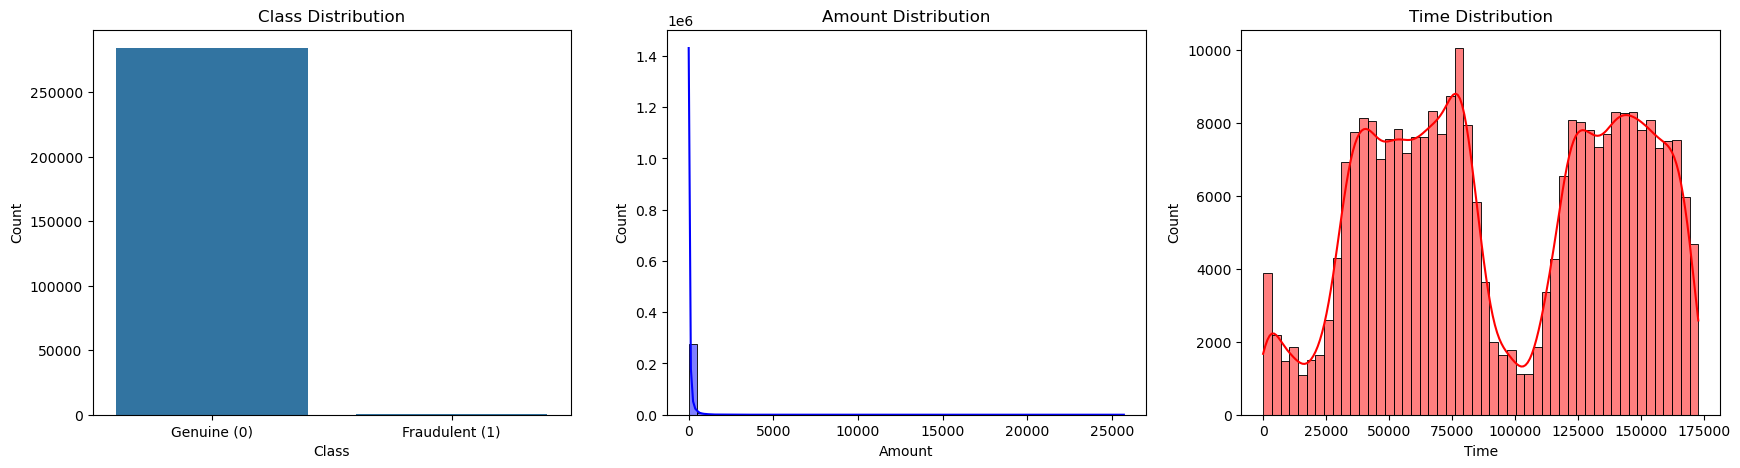

There are: 284315 non-fraudulent transactions and 492 fraudulent transactions
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467

In [14]:
class_counts = df['Class'].value_counts()

plt.figure(figsize=(21, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xticks([0, 1], ["Genuine (0)", "Fraudulent (1)"])
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.histplot(df['Amount'], bins=50, kde=True, color='blue')
plt.title('Amount Distribution')

plt.subplot(1, 3, 3)
sns.histplot(df['Time'], bins=50, kde=True, color='red')
plt.title('Time Distribution')

plt.show()

print(f"There are: {class_counts[0]} non-fraudulent transactions and {class_counts[1]} fraudulent transactions")

print(df.describe())

Immediate observations show that there are significantly more `non-fraudulent` transactions that `fraudulent` transactions. Out of the near 285 thousand transactions, only 492 were determined to be fraudulent. This is a percentage of only 0.17% of the total transactions that occurred. Furthermore, most of the transaction amounts are below $100 in that the mean is $88.34 where the median is $22.00. The only other variable can be interpreted is the time variable which is the time in seconds between transactions. This could potentially be useful but right now in its current form, it is not very useful.

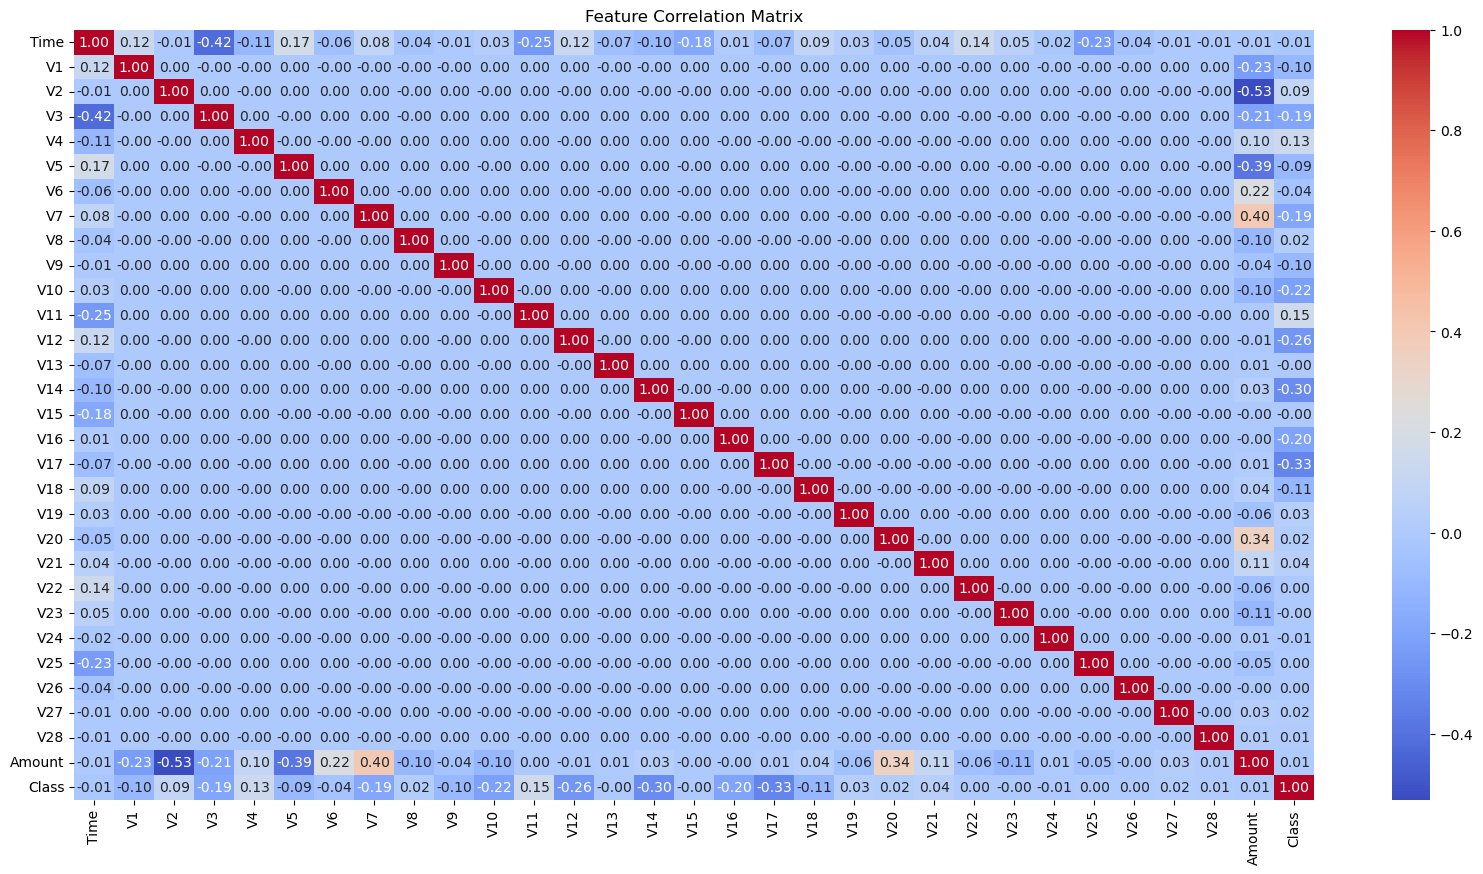

In [15]:
correlation_matrix = df.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

Immediate observations from the correlation matrix show that the features `V17` and `V14` have decent correlation with the `Class` variable. When producing a model with PCA components, one should include components that have a decent correlation with the variable that is being predicted. Surprisingly, the real life variables like `Time` and `Amount` have very little correlation with the `Class` variable. From this, we can clean some of our data right away by removing components from the PCA that have very little correlation with the `Class` variable.

In [16]:
correlation_threshold = 0.10

vip_features = correlation_matrix['Class'][abs(correlation_matrix['Class']) > correlation_threshold].index
print(f"The most important features with the correlation threshold of {correlation_threshold} are:\n {vip_features}")

# print(filtered_df.head())

The most important features with the correlation threshold of 0.1 are:
 Index(['V1', 'V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18',
       'Class'],
      dtype='object')


## <span style="color:red">Data Cleaning</span>

The data cleaning process for the building of the model is done with filtering the original dataset down to only the features that have a correlation threshold greater than 0.1. One can easily change this variable and create a different model but we will begin with 0.1 as the cutoff. In doing so, we are left with the following PCA components as features:

- V1
- V3
- V4
- V7
- V10
- V11
- V12
- V14
- V16
- V17
- V18

This cutoff was chosen because it was the lowest value that had a decent correlation with the `Class` variable. The `Time` and `Amount` variables were removed from the dataset because they had very little correlation with the `Class` variable.

In [17]:
filtered_df_cm10 = df[vip_features]

print(filtered_df_cm10.info)
print(filtered_df_cm10.head)

<bound method DataFrame.info of                V1        V3        V4        V7       V10       V11       V12  \
0       -1.359807  2.536347  1.378155  0.239599  0.090794 -0.551600 -0.617801   
1        1.191857  0.166480  0.448154 -0.078803 -0.166974  1.612727  1.065235   
2       -1.358354  1.773209  0.379780  0.791461  0.207643  0.624501  0.066084   
3       -0.966272  1.792993 -0.863291  0.237609 -0.054952 -0.226487  0.178228   
4       -1.158233  1.548718  0.403034  0.592941  0.753074 -0.822843  0.538196   
...           ...       ...       ...       ...       ...       ...       ...   
284802 -11.881118 -9.834783 -2.066656 -4.918215  4.356170 -1.593105  2.711941   
284803  -0.732789  2.035030 -0.738589  0.024330 -0.975926 -0.150189  0.915802   
284804   1.919565 -3.249640 -0.557828 -0.296827 -0.484782  0.411614  0.063119   
284805  -0.240440  0.702510  0.689799 -0.686180 -0.399126 -1.933849 -0.962886   
284806  -0.533413  0.703337 -0.506271  1.577006 -0.915427 -1.040458 -0.031513

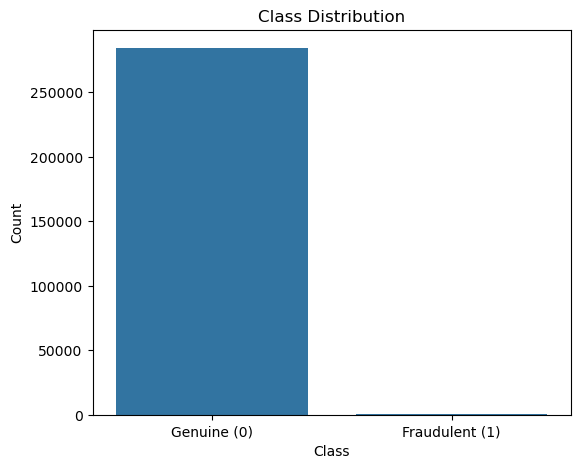

There are: 284315 non-fraudulent transactions and 492 fraudulent transactions
                 V1            V3            V4            V7           V10  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.168375e-15 -1.379537e-15  2.074095e-15 -5.556467e-16  2.239053e-15   
std    1.958696e+00  1.516255e+00  1.415869e+00  1.237094e+00  1.088850e+00   
min   -5.640751e+01 -4.832559e+01 -5.683171e+00 -4.355724e+01 -2.458826e+01   
25%   -9.203734e-01 -8.903648e-01 -8.486401e-01 -5.540759e-01 -5.354257e-01   
50%    1.810880e-02  1.798463e-01 -1.984653e-02  4.010308e-02 -9.291738e-02   
75%    1.315642e+00  1.027196e+00  7.433413e-01  5.704361e-01  4.539234e-01   
max    2.454930e+00  9.382558e+00  1.687534e+01  1.205895e+02  2.374514e+01   

                V11           V12           V14           V16           V17  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.673327e-15 -1.247012e-15  1.207294e-15  1.4

In [18]:
class_counts = filtered_df_cm10['Class'].value_counts()

plt.figure(figsize=(21, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xticks([0, 1], ["Genuine (0)", "Fraudulent (1)"])
plt.ylabel('Count')

plt.show()

print(f"There are: {class_counts[0]} non-fraudulent transactions and {class_counts[1]} fraudulent transactions")

print(filtered_df_cm10.describe())

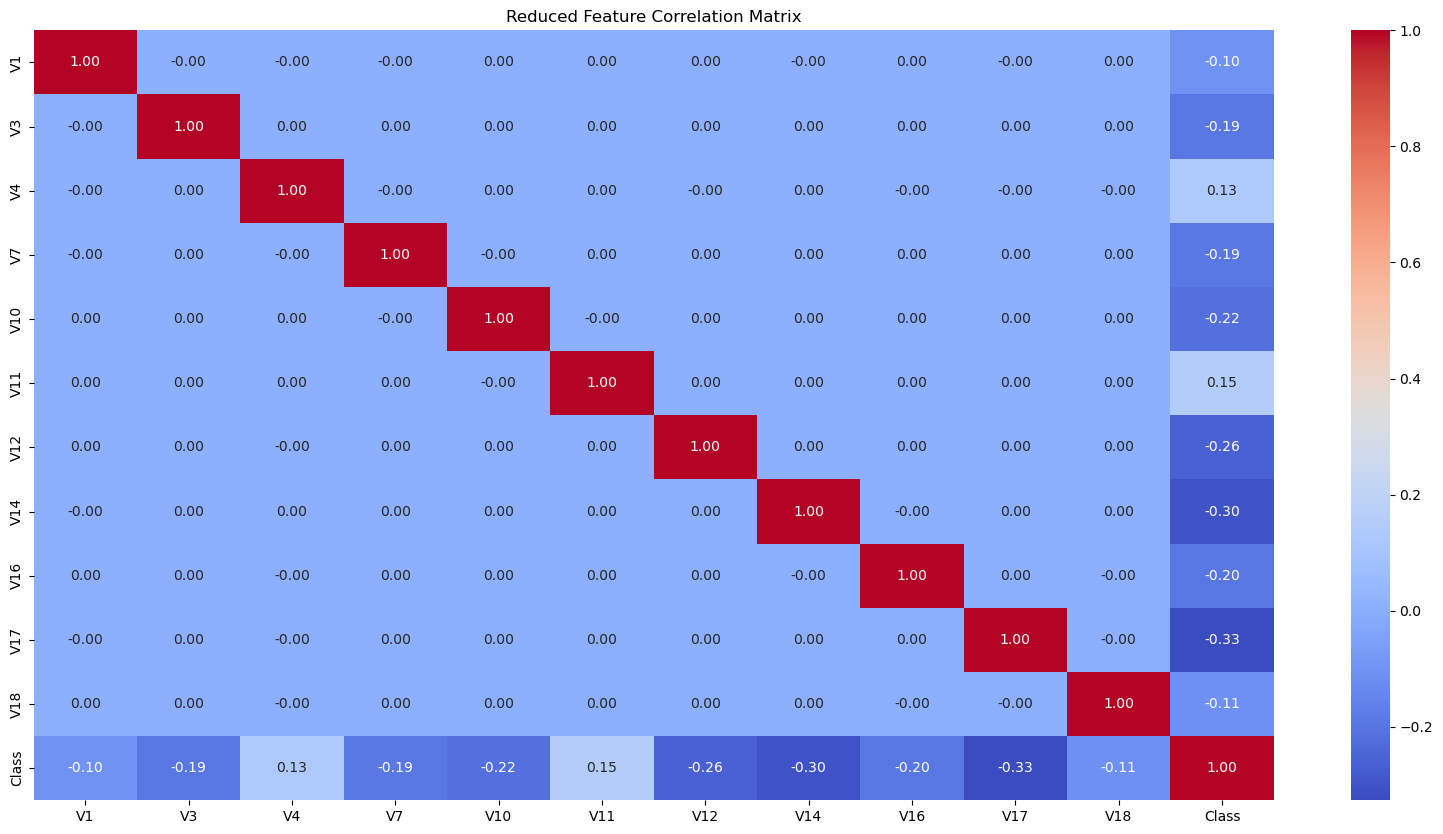

In [19]:
correlation_matrix = filtered_df_cm10.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Reduced Feature Correlation Matrix')
plt.show()

We now can create our model with these 11 features and then evaluate it to see how it performs.

# <span style="color:red">Training</span>

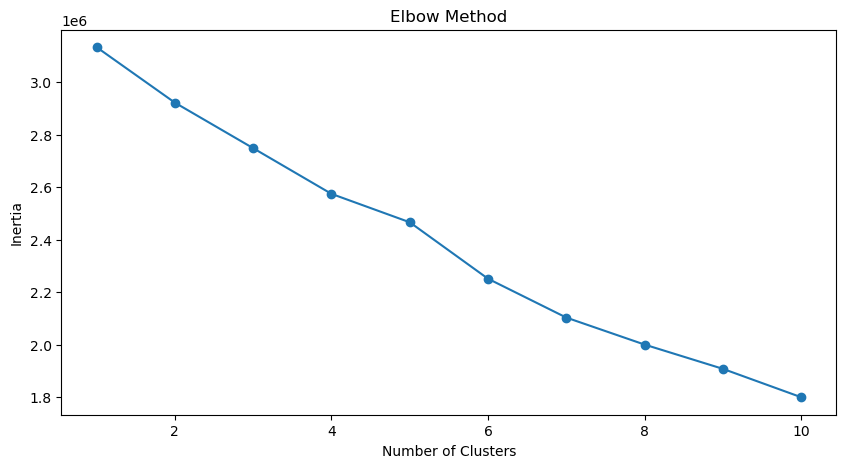

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Scale the data frame
features = filtered_df_cm10.drop('Class', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['Class'] = filtered_df_cm10['Class']

# Apply PCA
pca = PCA(n_components=0.95, random_state=42)
pca_features = pca.fit_transform(scaled_features)   
pca_df = pd.DataFrame(pca_features, columns=[f'PCA{i}' for i in range(1, pca.n_components_ + 1)])
pca_df['Class'] = filtered_df_cm10['Class']

# Clustering
inertia = []
k_range = range(1,11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

The `Elbow Method` is used to determine the optimal number of clusters for the K-Means algorithm. When using the `Elbow Method` one looks at the graph of Inertia versus Number of Clusters and inspects where the change in inertia begins to slow down. This then indicates the optimal number of clusters to use in the K-Means algorithm.

In our case, the optimal number of clusters is 5. One can see from the image above that an elbow begins to form around this number of clusters and thus this will be the number of clusters used to create the K-Means model.

Cluster      0      1      2      3      4
Class                                     
0        80072  75234  52059  41623  35327
1          112     47     35     11    287


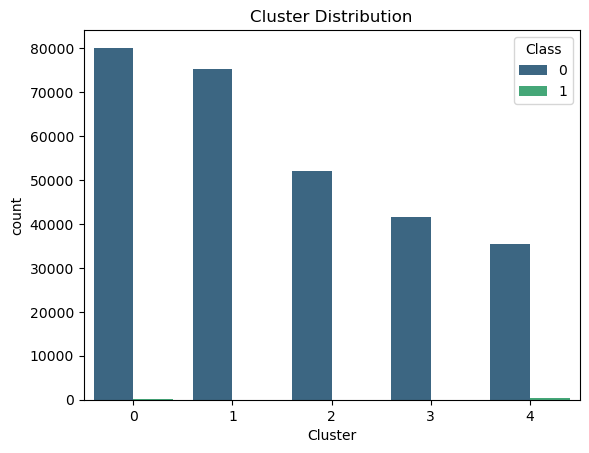

Inertia: 2465872.99
Cluster Purity: 1.00


In [26]:
optimal_k = 5

# Apply KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(pca_features)
pca_df['Cluster'] = cluster_labels

cross_tab = pd.crosstab(pca_df['Class'], pca_df['Cluster'])
print(cross_tab)

sns.countplot(data=pca_df, x='Cluster', hue='Class', palette='viridis')
plt.title('Cluster Distribution')
plt.show()

# Inertia
print(f"Inertia: {kmeans.inertia_:.2f}")

# Purity
print(f"Cluster Purity: {cross_tab.max(axis=0).sum() / cross_tab.sum().sum():.2f}")

We can tweak this process in a number of ways to see if it improves the model. The easiest way to do this is to change the number of clusters. Although we originally used the Elbow Method to determine the number of clusters, it is possible that a different number of clusters could improve the model.

Cluster       0      1       2
Class                         
0        108996  52122  123197
1           232     21     239


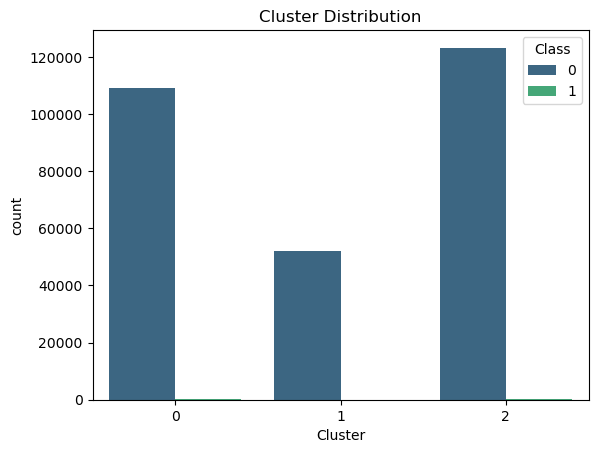

Inertia: 2748168.39
Cluster Purity: 1.00


In [27]:
optimal_k = 3

# Apply KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(pca_features)
pca_df['Cluster'] = cluster_labels

cross_tab = pd.crosstab(pca_df['Class'], pca_df['Cluster'])
print(cross_tab)

sns.countplot(data=pca_df, x='Cluster', hue='Class', palette='viridis')
plt.title('Cluster Distribution')
plt.show()

# Inertia
print(f"Inertia: {kmeans.inertia_:.2f}")

# Purity
print(f"Cluster Purity: {cross_tab.max(axis=0).sum() / cross_tab.sum().sum():.2f}")

Initially, changing the clusters to a lower number made the Inertia (the property that measures how spread out the clusters are) increase. A K-Means model with 3 clusters had an Inertia of `2.74E+6` while a K-Means model with 5 clusters had an Inertia of `2.46E+6`. This indicates that the model with 5 clusters is better than the model with 3 clusters. We can then test if increasing the number of clusters increases the models performance.

Cluster      0      1      2      3      4    5      6
Class                                                 
0        74197  69541  47863  40666  32631   42  19375
1           24     29     21      4    155  234     25


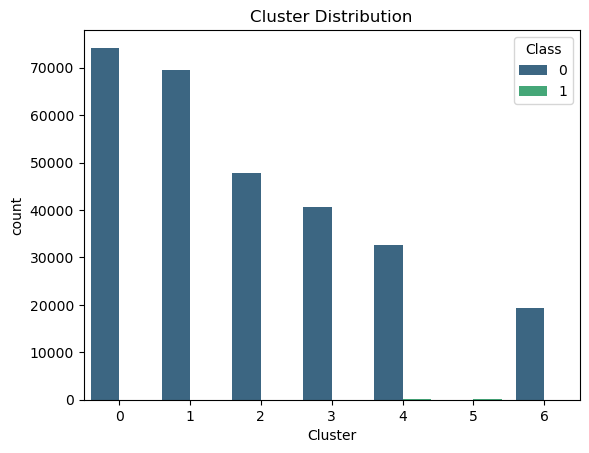

Inertia: 2102744.80
Cluster Purity: 1.00


In [41]:
optimal_k = 7

# Apply KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(pca_features)
pca_df['Cluster'] = cluster_labels

cross_tab = pd.crosstab(pca_df['Class'], pca_df['Cluster'])
print(cross_tab)

sns.countplot(data=pca_df, x='Cluster', hue='Class', palette='viridis')
plt.title('Cluster Distribution')
plt.show()

# Inertia
print(f"Inertia: {kmeans.inertia_:.2f}")

# Purity
print(f"Cluster Purity: {cross_tab.max(axis=0).sum() / cross_tab.sum().sum():.2f}")

If you max out the number of clusters with 10 we then have:

Cluster      0     1      2      3      4     5      6    7      8      9
Class                                                                    
0        43034  4971  61808  60418  31043  3645  19064   42  23946  36344
1           16     4     21     33    152     8     20  232      3      3


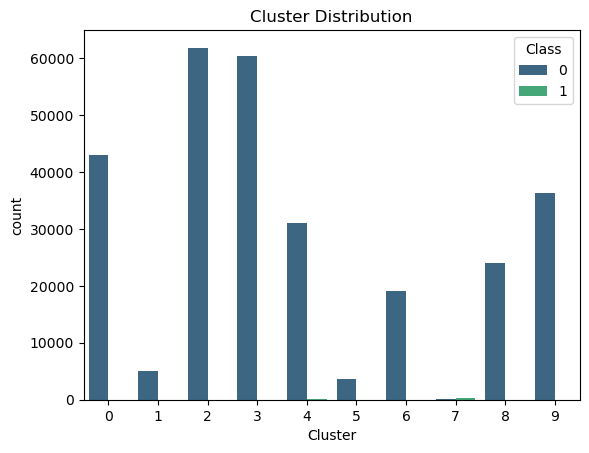

Inertia: 1799331.51
Cluster Purity: 1.00


In [42]:
optimal_k = 10

# Apply KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(pca_features)
pca_df['Cluster'] = cluster_labels

cross_tab = pd.crosstab(pca_df['Class'], pca_df['Cluster'])
print(cross_tab)

sns.countplot(data=pca_df, x='Cluster', hue='Class', palette='viridis')
plt.title('Cluster Distribution')
plt.show()

# Inertia
print(f"Inertia: {kmeans.inertia_:.2f}")

# Purity
print(f"Cluster Purity: {cross_tab.max(axis=0).sum() / cross_tab.sum().sum():.2f}")

We will now discuss the over all performance of the model and how it can be improved in future training.

# <span style="color:red">Evaluation</span>

The dataset that was gathered from Kaggle on credit card fraud detection. An unsupervised learning model was then trained off of cleaned data that was filtered down to only the features that had a correlation greater than 0.1 with the `Class` variable; A binary variable that indicates whether or not credit fraud has occurred.

After the dataset was filtered to only include features with a correlation greater than 0.1, the K-Means algorithm was then used to create a model with a given number of clusters. The models that were created had 3, 5, 7, and 10 clusters. The performance of these clusters can be seen in the table below:

| Number of Clusters | Inertia | Purity |
|--------------------|---------|--------|
| 3                  | 2.75E+6 | 1.0  |
| 5                  | 2.47E+6 | 1.0  |
| 7                  | 2.10E+6 | 1.0  |
| 10                 | 1.80E+6 | 1.0  |

The metrics that were used in the table above are called `Inertia` and `Purity`. Inertia is a property that measures how spread out the clusters are. The lower the inertia, the better the model. Purity is a metric that measures how pure the clusters are in the context of the dataset. The higher the purity, the better the model.

From the table above, one can see that the model with 10 clusters has the lowest inertia where the models had the same purity. The initial model was created with 5 clusters and this was from reading off the Elbow Method graph. The features that were chosen in this model were the PCA components in the original dataset as the real-world features had very little correlation with the `Class` variable. Future improvements of this model are discussed in the summary section.

# <span style="color:red">Summary</span>

When evaluating the models that were constructed for this project, `Inetertia` and `Purity` were used as metrics due to their ability to describe the clustering of each cluster in the model. During the EDA process, the number of features were widdled down to those that had a correlation greater than 0.1 with the `Class` variable. This was done to ensure that the model did not over fit due to having too many features.

Due to the familiarity with the K-Means algorithm from other courses, it was used for this project. The Elbow Method (reading the the change in inertia on a graph) was used to initially choose the number of clusters for the model. The model was then trained with 3, 5, 7, and 10 clusters to see how the model performed with different numbers of clusters. The model with 10 clusters had the lowest inertia and the highest purity. This model, with the other parameters set to the same, was found to be the best performing model.

Future improvements with using K-Means directly could include increasing the cutoff for the correlation of the features that were kept during the EDA process. This could potentially improve the model by removing features that have very little correlation with the predicted variable. Another improvement could be to use a different clustering algorithm for the model.

